In [44]:
import os
import random
import shutil

import pickle
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

from yellowbrick.cluster import silhouette_visualizer, intercluster_distance, kelbow_visualizer

# 1. Data collection and Annotation

In [45]:
# Define the image classes and the split ratios
classes = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
train_ratio = 0.4
val_ratio = 0.3
test_ratio = 0.3

# Create the output directories for each split
os.makedirs("images/train", exist_ok=True)
os.makedirs("images/val", exist_ok=True)
os.makedirs("images/test", exist_ok=True)

for cls in classes:
    # Get the list of image files for that class
    files = [file for file in os.listdir() if file.startswith(cls)]
    # Shuffle the files randomly with repeatable results using seed
    files = sorted(files)
    random.Random(42).shuffle(files)
    # Calculate the number of files for each split
    n_train = int(len(files) * train_ratio)
    n_val = int(len(files) * val_ratio)
    n_test = len(files) - n_train - n_val
    # Copy the files to the corresponding output directories
    for i, file in enumerate(files):
        src = file
        if i < n_train:
            dst = os.path.join("images/train", file)
        elif i < n_train + n_val:
            dst = os.path.join("images/val", file)
        else:
            dst = os.path.join("images/test", file)
        shutil.copy(src, dst)

In [46]:
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
    
    def learn(self):
        sift = cv.SIFT_create()
        num_keypoints = [] #this is used to store the number of keypoints in each image
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
        return training_word_histograms

    def create_word_histograms(self, img_filenames):
        sift = cv.SIFT_create()
        histograms = []
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

# Labelling training, validation and testing data

In [47]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
validation_file_names = []
validation_breed_labels = []
testing_file_names = []
testing_breed_labels = []
for i, breed in enumerate(breeds):
    # Training Data
    sub_path = path + 'train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels
    # Validation Data
    sub_path = path + 'val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_breed_labels += sub_breed_labels
    # Testing Data
    sub_path = path + 'test/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    testing_file_names += sub_file_names
    testing_breed_labels += sub_breed_labels

print(training_file_names)
print(training_breed_labels)

print(validation_file_names)
print(validation_breed_labels)

print(testing_file_names)
print(testing_breed_labels)

['images/train/shiba_inu_1.jpg', 'images/train/shiba_inu_100.jpg', 'images/train/shiba_inu_101.jpg', 'images/train/shiba_inu_103.jpg', 'images/train/shiba_inu_108.jpg', 'images/train/shiba_inu_11.jpg', 'images/train/shiba_inu_110.jpg', 'images/train/shiba_inu_111.jpg', 'images/train/shiba_inu_112.jpg', 'images/train/shiba_inu_113.jpg', 'images/train/shiba_inu_116.jpg', 'images/train/shiba_inu_126.jpg', 'images/train/shiba_inu_128.jpg', 'images/train/shiba_inu_131.jpg', 'images/train/shiba_inu_132.jpg', 'images/train/shiba_inu_133.jpg', 'images/train/shiba_inu_137.jpg', 'images/train/shiba_inu_139.jpg', 'images/train/shiba_inu_14.jpg', 'images/train/shiba_inu_140.jpg', 'images/train/shiba_inu_141.jpg', 'images/train/shiba_inu_142.jpg', 'images/train/shiba_inu_147.jpg', 'images/train/shiba_inu_150.jpg', 'images/train/shiba_inu_157.jpg', 'images/train/shiba_inu_158.jpg', 'images/train/shiba_inu_160.jpg', 'images/train/shiba_inu_161.jpg', 'images/train/shiba_inu_162.jpg', 'images/train/shi

In [48]:
sift = cv.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

training_data = np.array(training_data)

# 2.1 K-elbow Visualization

Generating kelbow plot...


c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\clust

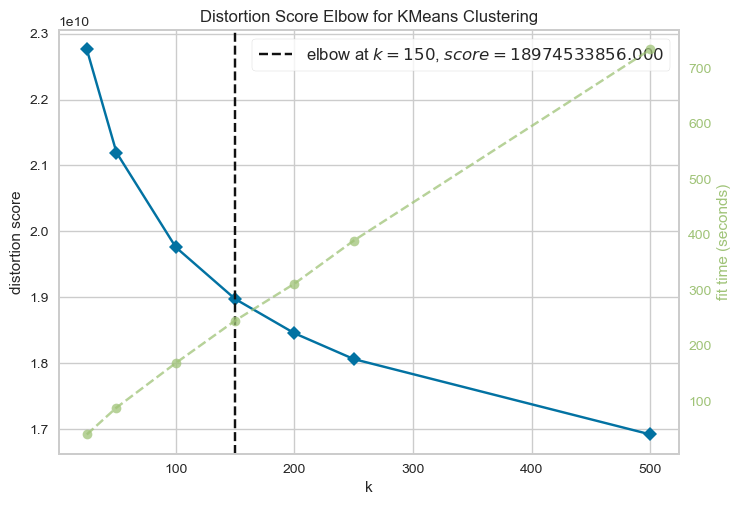

c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\clust

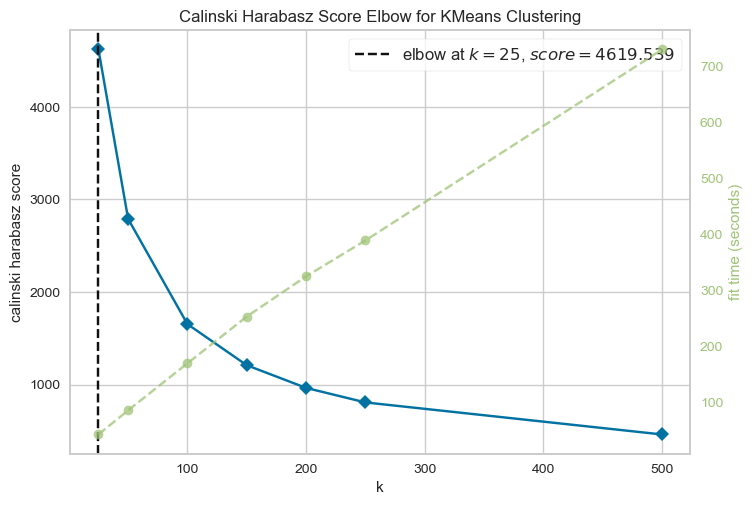

In [49]:
# Kelbow distortion plot
print("Generating kelbow plot...")
kelbow_vis_distortion = kelbow_visualizer(KMeans(), training_data, k=[25,50,100,150,200,250,500], metric="distortion")

# Kelbow calinski_harabasz plot
kelbow_vis_calinski = kelbow_visualizer(KMeans(), training_data, k=[25,50,100,150,200,250,500], metric="calinski_harabasz")

In [50]:
num_words = 50
dictionary_name = 'breeds'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

In [51]:
training_word_histograms = dictionary.learn()
validation_word_histograms = dictionary.create_word_histograms(validation_file_names)
testing_word_histograms = dictionary.create_word_histograms(testing_file_names)

c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
# Save Dictionary
with open('breeds_dictionary.dic', 'wb') as f: #'wb' is for binary write
    pickle.dump(dictionary, f)

In [53]:
# Read Dictionary
with open('breeds_dictionary.dic', 'rb') as f: #'rb' is for binary read
    dictionary = pickle.load(f)

# 2.1 Training SVM with varying values of C

In [54]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
C = [0.1, 1, 10, 20, 30, 40, 50, 100]

In [55]:
for c in C:
    # SVM classifier
    svm_classifier = svm.SVC(C = c, kernel = 'linear')
    svm_classifier.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = svm_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = svm_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on testing dataset
    testing_pred = svm_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

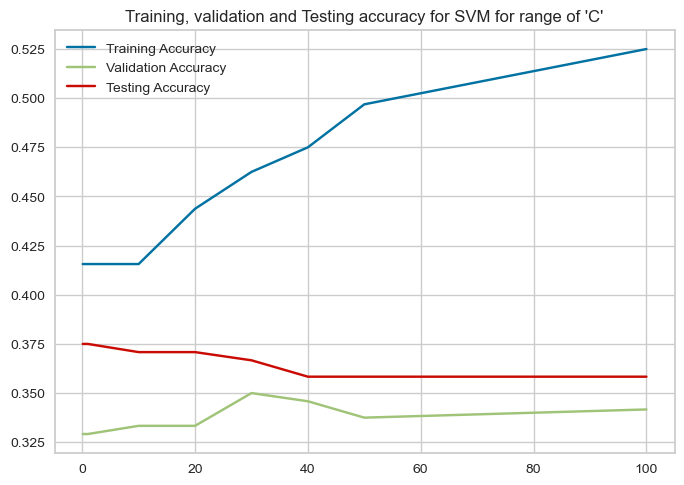

In [56]:
# Plot the results
plt.plot(C, training_accuracies, label='Training Accuracy')
plt.plot(C, validation_accuracies, label='Validation Accuracy')
plt.plot(C, testing_accuracies, label='Testing Accuracy')
plt.legend()
plt.title("Training, validation and Testing accuracy for SVM for range of 'C'")
plt.show()

In [57]:
for c, validation_accuracy in zip(C, validation_accuracies):
    print("Prediction accuracy of SVM model on validation dataset when C = %s is %s" % (c, validation_accuracy))

Prediction accuracy of SVM model on validation dataset when C = 0.1 is 0.32916666666666666
Prediction accuracy of SVM model on validation dataset when C = 1 is 0.32916666666666666
Prediction accuracy of SVM model on validation dataset when C = 10 is 0.3333333333333333
Prediction accuracy of SVM model on validation dataset when C = 20 is 0.3333333333333333
Prediction accuracy of SVM model on validation dataset when C = 30 is 0.35
Prediction accuracy of SVM model on validation dataset when C = 40 is 0.3458333333333333
Prediction accuracy of SVM model on validation dataset when C = 50 is 0.3375
Prediction accuracy of SVM model on validation dataset when C = 100 is 0.3416666666666667


# 2.2 Training SVM with the best C hyperparameter

In [58]:
best_c = C[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The best C for SVM model is {best_c} with a validation accuracy of {best_val_acc:.2%}")

The best C for SVM model is 30 with a validation accuracy of 35.00%


In [59]:
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)

SVC(C=30, kernel='linear')

In [60]:
predicted_breed_labels = svm_classifier.predict(validation_word_histograms)
print('Breed label: ', predicted_breed_labels)

Breed label:  [1 3 2 2 0 2 0 2 2 2 2 0 0 2 2 2 2 2 0 3 2 2 3 2 2 2 2 1 2 2 2 3 0 1 2 0 2
 3 3 0 0 0 1 2 0 2 2 2 0 3 2 2 2 1 2 2 2 2 2 2 2 2 2 0 2 0 1 0 0 1 1 2 2 1
 1 3 2 2 1 1 1 1 2 2 0 1 2 2 1 3 2 2 2 1 3 0 2 1 2 1 0 2 2 3 3 1 2 2 1 3 2
 2 1 0 2 2 2 1 2 2 2 2 2 1 1 2 1 2 2 2 3 2 2 2 2 1 1 1 1 2 2 2 2 2 1 2 0 1
 2 2 2 2 0 1 2 2 3 1 1 2 1 3 0 2 1 0 2 2 2 2 2 1 2 1 1 2 2 2 2 2 3 2 2 3 3
 3 3 2 0 3 3 0 0 1 3 1 2 3 3 0 2 2 2 3 1 3 3 1 2 1 1 1 2 2 3 2 2 2 0 2 0 2
 3 1 2 2 2 0 2 3 0 1 3 2 0 3 0 2 2 2]


The best value of C is 0.1 for testing data with an accuracy of 35.00%


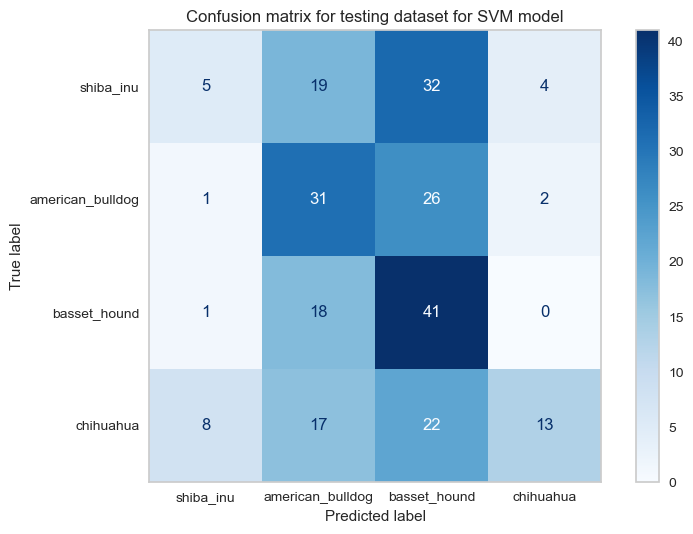

In [61]:
# best C for testing data
best_c = C[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of C is {best_c} for testing data with an accuracy of {best_val_acc:.2%}")
# C = best_c SVM classification
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on test data using best C hyperparameter
predicted_breed_labels = svm_classifier.predict(testing_word_histograms)
# Generating a confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Blues) # use a blue color map
plt.title('Confusion matrix for testing dataset for SVM model')
plt.tight_layout()
plt.grid(False)
plt.show()

# 2.1 Training Adaboost with varying values of n_estimator

In [62]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
n_estimator_range = [50, 100, 150, 200, 250]

In [63]:
for n_estimator in n_estimator_range:
    # Adaboost classifier
    adb_classifier = AdaBoostClassifier(n_estimators = n_estimator, random_state = 0)
    adb_classifier.fit(training_word_histograms, training_breed_labels)
    
    # Get accuracy on training dataset
    training_pred = adb_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = adb_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on testing dataset
    testing_pred = adb_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

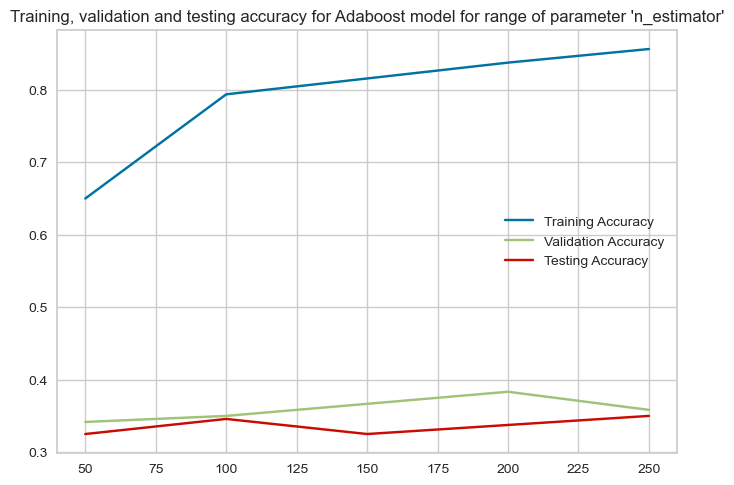

In [64]:
# Plot the results
plt.plot(n_estimator_range, training_accuracies, label='Training Accuracy')
plt.plot(n_estimator_range, validation_accuracies, label='Validation Accuracy')
plt.plot(n_estimator_range, testing_accuracies, label='Testing Accuracy')
plt.legend()
plt.title("Training, validation and testing accuracy for Adaboost model for range of parameter 'n_estimator'")
plt.show()

In [65]:
for n_estimator, validation_accuracy in zip(n_estimator_range, validation_accuracies):
    print("Prediction accuracy of Adaboost model on validation dataset when n_estimators = %s is %s" % (n_estimator, validation_accuracy))

Prediction accuracy of Adaboost model on validation dataset when n_estimators = 50 is 0.3416666666666667
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 100 is 0.35
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 150 is 0.36666666666666664
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 200 is 0.38333333333333336
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 250 is 0.35833333333333334


# 2.2 Training Adaboost with best n_estimator

In [66]:
best_n = n_estimator_range[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The best value of N-estimator for Adaboost model is {best_n} with an accuracy of {best_val_acc:.2%}")

The best value of N-estimator for Adaboost model is 200 with an accuracy of 38.33%


In [67]:
# Training on best parameters
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [68]:
predicted_breed_labels = adb_classifier.predict(validation_word_histograms)
print('Breed label: ', predicted_breed_labels)

Breed label:  [3 2 0 2 3 2 0 2 1 1 0 1 3 1 2 2 1 2 2 3 0 3 0 1 1 2 1 1 1 2 1 0 1 3 1 0 1
 3 1 0 3 0 2 1 3 3 0 2 2 2 1 1 0 0 1 2 3 2 2 2 2 0 3 2 1 0 1 0 1 1 1 2 1 1
 1 3 0 0 3 3 1 1 2 1 1 1 1 1 3 1 2 1 2 1 1 2 1 1 3 1 0 1 3 0 0 1 1 0 1 0 0
 1 1 0 2 0 1 1 1 0 1 2 2 1 1 2 1 1 2 1 1 2 2 2 1 3 1 0 2 3 2 1 2 1 3 1 2 1
 2 0 2 1 2 1 2 2 3 2 1 1 1 3 3 2 1 1 2 2 1 2 3 1 2 3 2 2 2 1 2 1 3 3 3 1 3
 3 0 1 0 3 3 3 1 1 1 3 0 3 3 1 2 3 0 3 1 0 2 1 1 1 1 2 2 3 2 2 1 3 0 1 2 2
 3 3 3 3 1 3 0 1 0 0 3 3 3 2 0 0 1 2]


The best value of n-estimators is 250 for testing data with an accuracy of 38.33%


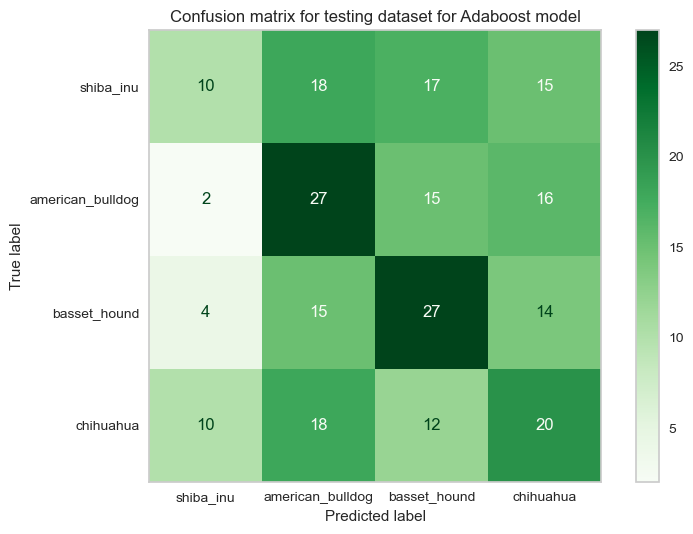

In [69]:
best_n = n_estimator_range[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of n-estimators is {best_n} for testing data with an accuracy of {best_val_acc:.2%}")
# Training on best parameters
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on best parameters using Test data
predicted_breed_labels = adb_classifier.predict(testing_word_histograms)
# Confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Greens) # use a blue color map
plt.title('Confusion matrix for testing dataset for Adaboost model')
plt.tight_layout()
plt.grid(False)
plt.show()

# Removing background for train, val and test data

In [70]:
# Make output directories
os.makedirs("images/filtered_train", exist_ok=True)
os.makedirs("images/filtered_val", exist_ok=True)
os.makedirs("images/filtered_test", exist_ok=True)

# Get the list of files in the images folder
files = os.listdir("images/train/")

for file in files:
    # Check if the file is an image
    if file.endswith(".jpg"):
        # Load the image and the trimap as grayscale images
        image = cv.imread("images/train/" + file)
        trimap = cv.imread("annotations/trimaps/" + file[:-4] + ".png", cv.IMREAD_GRAYSCALE)

        mask = np.zeros(trimap.shape, np.uint8)
        mask[trimap == 2] = cv.GC_BGD # background
        mask[trimap == 1] = cv.GC_FGD # foreground
        mask[trimap == 0] = cv.GC_PR_FGD # probably foreground

        # Create a binary mask for the foreground and background regions
        fg_mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
        bg_mask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 255, 0).astype(np.uint8)

        # Apply bitwise operations to extract the foreground and background pixels from the image using the mask
        fg = cv.bitwise_and(image, image, mask=fg_mask)
        bg = cv.bitwise_and(image, image, mask=bg_mask)

        # write the results
        cv.imwrite("images/filtered_train/" + file, fg)

# Get the list of files in the images folder
files = os.listdir("images/val/")

for file in files:
    # Check if the file is an image
    if file.endswith(".jpg"):
        # Load the image and the trimap as grayscale images
        image = cv.imread("images/val/" + file)
        trimap = cv.imread("annotations/trimaps/" + file[:-4] + ".png", cv.IMREAD_GRAYSCALE)

        mask = np.zeros(trimap.shape, np.uint8)
        mask[trimap == 2] = cv.GC_BGD # background
        mask[trimap == 1] = cv.GC_FGD # foreground
        mask[trimap == 0] = cv.GC_PR_FGD # probably foreground

        # Create a binary mask for the foreground and background regions
        fg_mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
        bg_mask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 255, 0).astype(np.uint8)

        # Apply bitwise operations to extract the foreground and background pixels from the image using the mask
        fg = cv.bitwise_and(image, image, mask=fg_mask)
        bg = cv.bitwise_and(image, image, mask=bg_mask)

        # write the results
        cv.imwrite("images/filtered_val/" + file, fg)

# Get the list of files in the images folder
files = os.listdir("images/test/")

for file in files:
    # Check if the file is an image
    if file.endswith(".jpg"):
        # Load the image and the trimap as grayscale images
        image = cv.imread("images/test/" + file)
        trimap = cv.imread("annotations/trimaps/" + file[:-4] + ".png", cv.IMREAD_GRAYSCALE)

        mask = np.zeros(trimap.shape, np.uint8)
        mask[trimap == 2] = cv.GC_BGD # background
        mask[trimap == 1] = cv.GC_FGD # foreground
        mask[trimap == 0] = cv.GC_PR_FGD # probably foreground

        # Create a binary mask for the foreground and background regions
        fg_mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
        bg_mask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 255, 0).astype(np.uint8)

        # Apply bitwise operations to extract the foreground and background pixels from the image using the mask
        fg = cv.bitwise_and(image, image, mask=fg_mask)
        bg = cv.bitwise_and(image, image, mask=bg_mask)

        # write the results
        cv.imwrite("images/filtered_test/" + file, fg)

# Labelling training, validation and testing data after background removal

In [71]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
validation_file_names = []
validation_breed_labels = []
testing_file_names = []
testing_breed_labels = []
testing_file_names_bg_removed = []
for i, breed in enumerate(breeds):
    # Training Data
    sub_path = path + 'filtered_train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels
    # Validation Data
    sub_path = path + 'filtered_val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_breed_labels += sub_breed_labels
    # Testing Data
    sub_path = path + 'test/'
    sub_path_bg_rm = path + 'filtered_test/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_file_names_bg_rm = [os.path.join(sub_path_bg_rm, file) for file in os.listdir(sub_path_bg_rm) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    testing_file_names += sub_file_names
    testing_breed_labels += sub_breed_labels
    testing_file_names_bg_removed += sub_file_names_bg_rm

print(training_file_names)
print(training_breed_labels)

print(validation_file_names)
print(validation_breed_labels)

print(testing_file_names)
print(testing_breed_labels)

['images/filtered_train/shiba_inu_1.jpg', 'images/filtered_train/shiba_inu_100.jpg', 'images/filtered_train/shiba_inu_101.jpg', 'images/filtered_train/shiba_inu_103.jpg', 'images/filtered_train/shiba_inu_108.jpg', 'images/filtered_train/shiba_inu_11.jpg', 'images/filtered_train/shiba_inu_110.jpg', 'images/filtered_train/shiba_inu_111.jpg', 'images/filtered_train/shiba_inu_112.jpg', 'images/filtered_train/shiba_inu_113.jpg', 'images/filtered_train/shiba_inu_116.jpg', 'images/filtered_train/shiba_inu_126.jpg', 'images/filtered_train/shiba_inu_128.jpg', 'images/filtered_train/shiba_inu_131.jpg', 'images/filtered_train/shiba_inu_132.jpg', 'images/filtered_train/shiba_inu_133.jpg', 'images/filtered_train/shiba_inu_137.jpg', 'images/filtered_train/shiba_inu_139.jpg', 'images/filtered_train/shiba_inu_14.jpg', 'images/filtered_train/shiba_inu_140.jpg', 'images/filtered_train/shiba_inu_141.jpg', 'images/filtered_train/shiba_inu_142.jpg', 'images/filtered_train/shiba_inu_147.jpg', 'images/filter

In [72]:
sift = cv.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

training_data = np.array(training_data)

In [73]:
num_words = 50
dictionary_name = 'breeds'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

In [74]:
training_word_histograms = dictionary.learn()
validation_word_histograms = dictionary.create_word_histograms(validation_file_names)
testing_word_histograms = dictionary.create_word_histograms(testing_file_names)
testing_word_histograms_bg_rm = dictionary.create_word_histograms(testing_file_names_bg_removed)

c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# 2.1 Training SVM with varying values of C (Background Removed)

In [75]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
testing_accuracies_bg_rm = []
C = [0.1, 1, 10, 20, 30, 40, 50, 100]

In [76]:
for c in C:
    # SVM classifier
    svm_classifier = svm.SVC(C = c, kernel = 'linear')
    svm_classifier.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on background removed training dataset
    training_pred = svm_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on background removed validation dataset
    validation_pred = svm_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on normal testing dataset
    testing_pred = svm_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

    # Get accuracy on background removed testing dataset
    testing_pred_bg_rm = svm_classifier.predict(testing_word_histograms_bg_rm)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred_bg_rm)
    testing_accuracies_bg_rm.append(testing_acc)

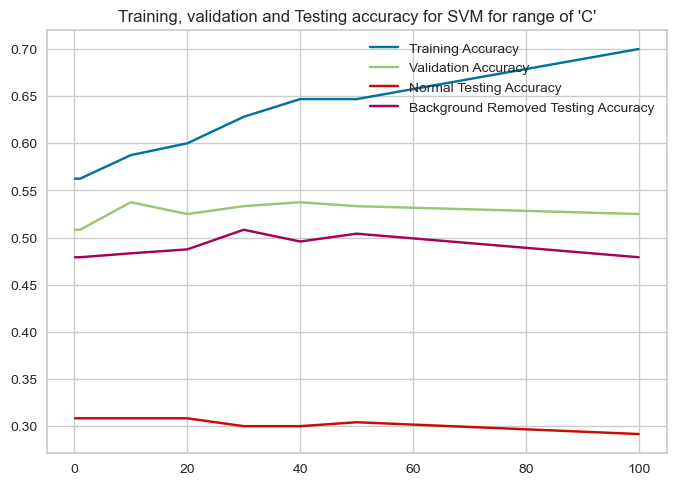

In [77]:
# Plot the results
plt.plot(C, training_accuracies, label='Training Accuracy')
plt.plot(C, validation_accuracies, label='Validation Accuracy')
plt.plot(C, testing_accuracies, label='Normal Testing Accuracy')
plt.plot(C, testing_accuracies_bg_rm, label='Background Removed Testing Accuracy')
plt.legend()
plt.title("Training, validation and Testing accuracy for SVM for range of 'C'")
plt.show()

The best value of C is 0.1 for testing data with an accuracy of 38.33%


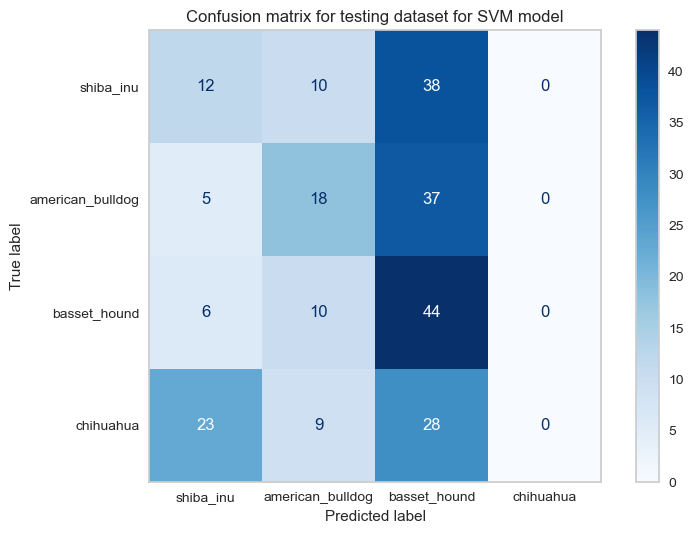

In [78]:
# best C for normal testing data
best_c = C[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of C is {best_c} for testing data with an accuracy of {best_val_acc:.2%}")
# C = best_c SVM classification
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on test data using best C hyperparameter
predicted_breed_labels = svm_classifier.predict(testing_word_histograms)
# Generating a confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Blues) # use a blue color map
plt.title('Confusion matrix for testing dataset for SVM model')
plt.tight_layout()
plt.grid(False)
plt.show()

The best value of C is 30 for testing data with an accuracy of 38.33%


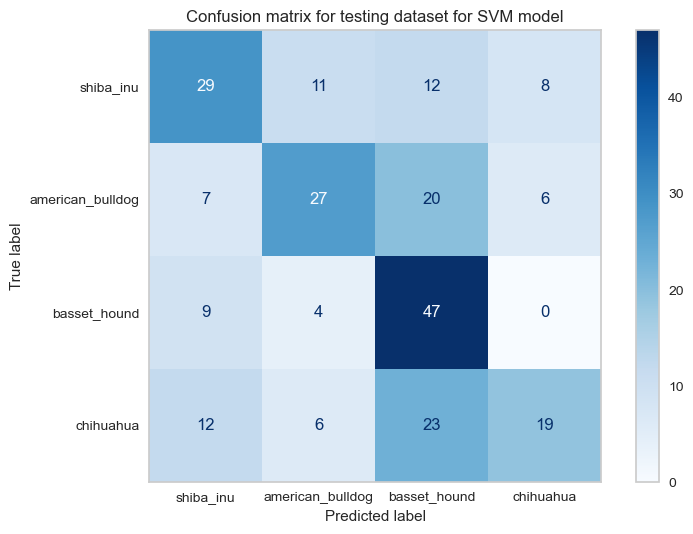

In [79]:
# best C for background removed testing data
best_c = C[np.argmax(testing_accuracies_bg_rm)]
best_test_acc = max(testing_accuracies_bg_rm)
print(f"The best value of C is {best_c} for testing data with an accuracy of {best_val_acc:.2%}")
# C = best_c SVM classification
svm_classifier_bg_rm = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier_bg_rm.fit(training_word_histograms, training_breed_labels)
# Testing on test data using best C hyperparameter
predicted_breed_labels_bg_rm = svm_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
# Generating a confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels_bg_rm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Blues) # use a blue color map
plt.title('Confusion matrix for testing dataset for SVM model')
plt.tight_layout()
plt.grid(False)
plt.show()

# 2.1 Training Adaboost with varying values of n_estimator (Background Removed)

In [80]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
testing_accuracies_bg_rm = []
n_estimator_range = [50, 100, 150, 200, 250]

In [81]:
for n_estimator in n_estimator_range:
    # Adaboost classifier
    adb_classifier = AdaBoostClassifier(n_estimators = n_estimator, random_state = 0)
    adb_classifier.fit(training_word_histograms, training_breed_labels)
    
    # Get accuracy on training dataset
    training_pred = adb_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = adb_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on testing dataset
    testing_pred = adb_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

    # Get accuracy on background removed testing dataset
    testing_pred_bg_rm = adb_classifier.predict(testing_word_histograms_bg_rm)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred_bg_rm)
    testing_accuracies_bg_rm.append(testing_acc)

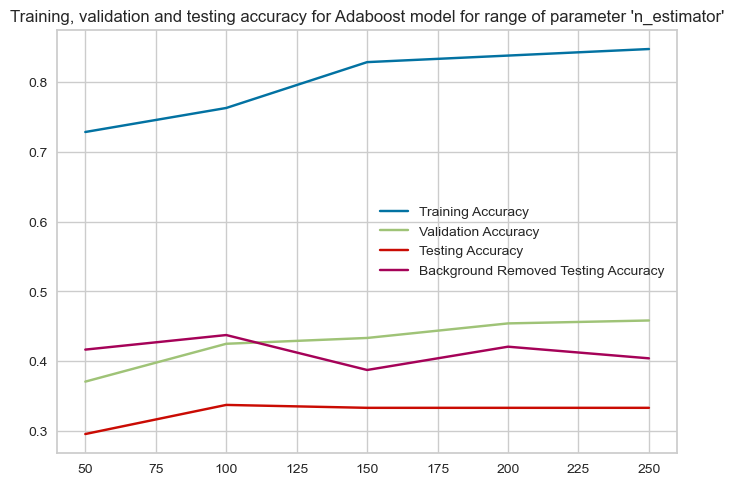

In [82]:
# Plot the results
plt.plot(n_estimator_range, training_accuracies, label='Training Accuracy')
plt.plot(n_estimator_range, validation_accuracies, label='Validation Accuracy')
plt.plot(n_estimator_range, testing_accuracies, label='Testing Accuracy')
plt.plot(n_estimator_range, testing_accuracies_bg_rm, label='Background Removed Testing Accuracy')
plt.legend()
plt.title("Training, validation and testing accuracy for Adaboost model for range of parameter 'n_estimator'")
plt.show()

The best value of n-estimators is 100 for testing data with an accuracy of 38.33%


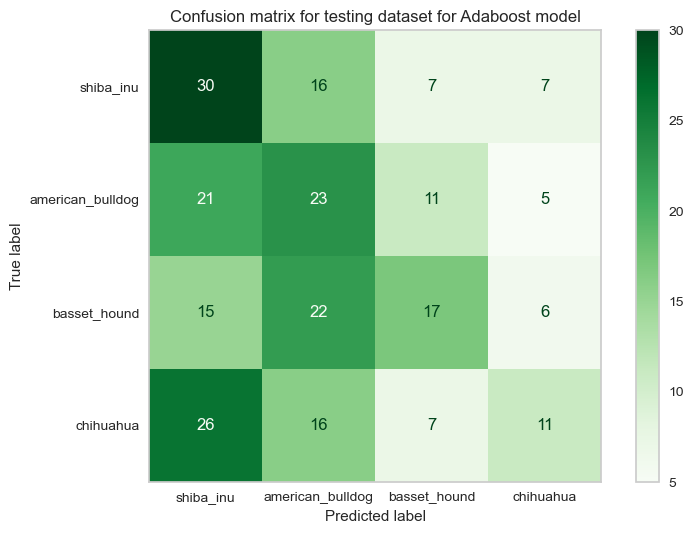

In [83]:
# best n_estimators for normal testing data
best_n = n_estimator_range[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of n-estimators is {best_n} for testing data with an accuracy of {best_val_acc:.2%}")
# Training on best parameters
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on best parameters using Test data
predicted_breed_labels = adb_classifier.predict(testing_word_histograms)
# Confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Greens) # use a blue color map
plt.title('Confusion matrix for testing dataset for Adaboost model')
plt.tight_layout()
plt.grid(False)
plt.show()

The best value of n-estimators is 100 for testing data with an accuracy of 38.33%


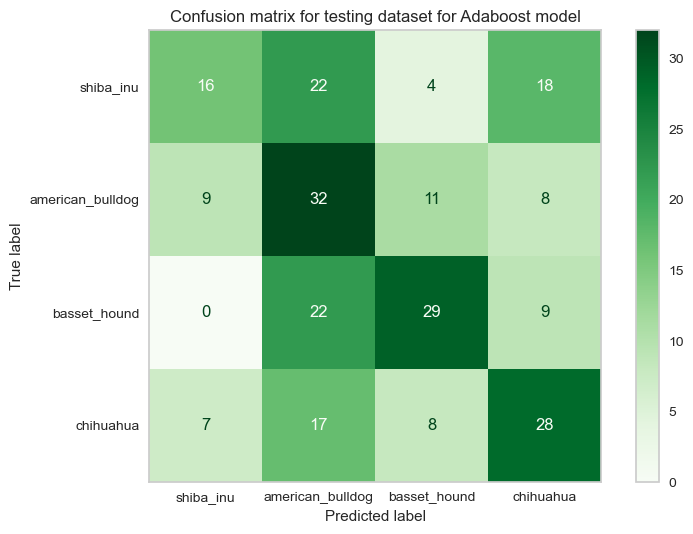

In [84]:
# best n_estimators for background removed testing data
best_n = n_estimator_range[np.argmax(testing_accuracies_bg_rm)]
best_test_acc = max(testing_accuracies_bg_rm)
print(f"The best value of n-estimators is {best_n} for testing data with an accuracy of {best_val_acc:.2%}")
# Training on best parameters
adb_classifier_bg_rm = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier_bg_rm.fit(training_word_histograms, training_breed_labels)
# Testing on best parameters using Test data
predicted_breed_labels_bg_rm = adb_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
# Confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels_bg_rm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Greens) # use a blue color map
plt.title('Confusion matrix for testing dataset for Adaboost model')
plt.tight_layout()
plt.grid(False)
plt.show()

The accuracy on the unmodified test dataset for the SVM model trained on unmodified images is 30.83%
The accuracy on the unmodified test dataset for the SVM model trained on background removed images is 30.00%
The accuracy on the background removed test dataset for the SVM model trained on background removed images is 50.83%
The accuracy on the unmodified test dataset for the Adaboost model trained on unmodified images is 33.75%
The accuracy on the unmodified test dataset for the Adaboost model trained on background removed images is 33.75%
The accuracy on the background removed test dataset for the Adaboost model trained on background removed images is 43.75%


,SVM,Adaboost
Unmodified test dataset +\ntrained on unmodified images,0.308333,0.3375
Unmodified test dataset +\ntrained on background removed images,0.300000,0.3375
Background Removed test dataset +\ntrained on background removed images,0.508333,0.4375


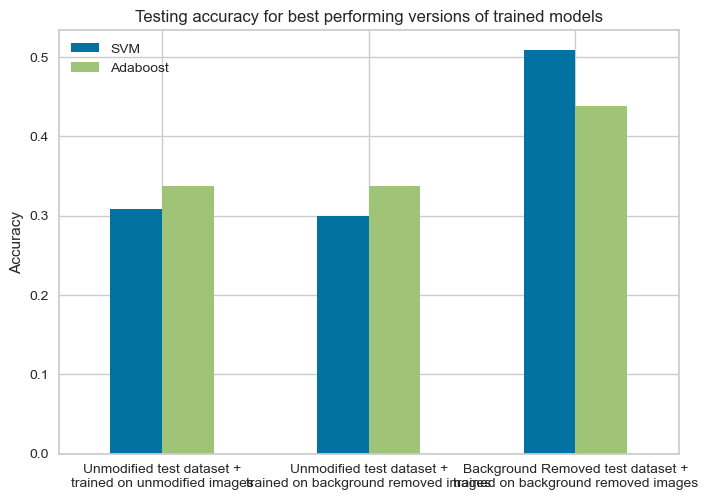

<Figure size 1500x700 with 0 Axes>

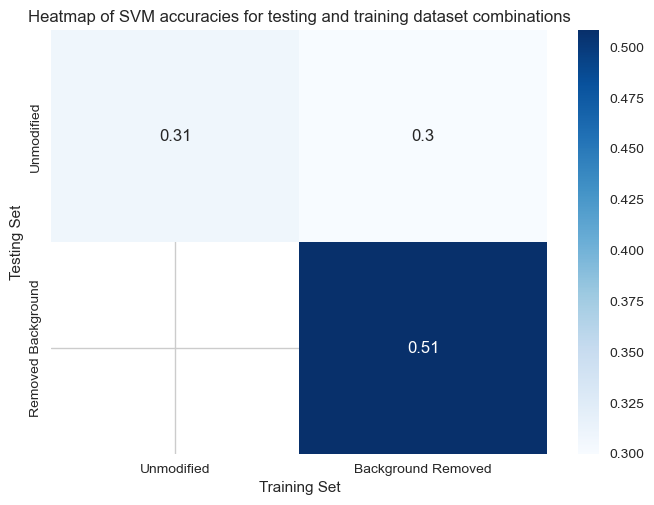

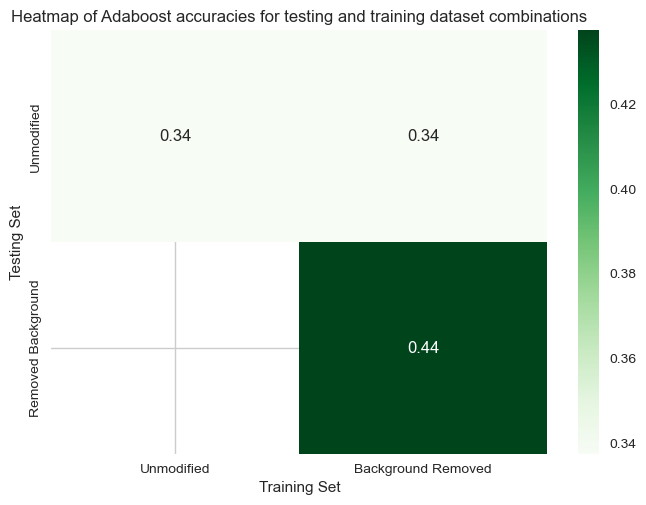

In [85]:
svm_predicted_labels = svm_classifier.predict(testing_word_histograms)
adb_predicted_labels = adb_classifier.predict(testing_word_histograms)
svm_predicted_labels_no_mod = svm_classifier_bg_rm.predict(testing_word_histograms)
adb_predicted_labels_no_mod = adb_classifier_bg_rm.predict(testing_word_histograms)
svm_predicted_labels_bg_rm = svm_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
adb_predicted_labels_bg_rm = adb_classifier_bg_rm.predict(testing_word_histograms_bg_rm)

svm_test_acc = accuracy_score(testing_breed_labels, svm_predicted_labels)
svm_test_acc_no_mod = accuracy_score(testing_breed_labels, svm_predicted_labels_no_mod)
svm_test_acc_bg_rm = accuracy_score(testing_breed_labels, svm_predicted_labels_bg_rm)
print(f"The accuracy on the unmodified test dataset for the SVM model trained on unmodified images is {svm_test_acc:.2%}")
print(f"The accuracy on the unmodified test dataset for the SVM model trained on background removed images is {svm_test_acc_no_mod:.2%}")
print(f"The accuracy on the background removed test dataset for the SVM model trained on background removed images is {svm_test_acc_bg_rm:.2%}")

adb_test_acc = accuracy_score(testing_breed_labels, adb_predicted_labels)
adb_test_acc_no_mod = accuracy_score(testing_breed_labels, adb_predicted_labels_no_mod)
adb_test_acc_bg_rm = accuracy_score(testing_breed_labels, adb_predicted_labels_bg_rm)
print(f"The accuracy on the unmodified test dataset for the Adaboost model trained on unmodified images is {adb_test_acc:.2%}")
print(f"The accuracy on the unmodified test dataset for the Adaboost model trained on background removed images is {adb_test_acc_no_mod:.2%}")
print(f"The accuracy on the background removed test dataset for the Adaboost model trained on background removed images is {adb_test_acc_bg_rm:.2%}")


measurements = [
    "Unmodified test dataset +\ntrained on unmodified images",
    "Unmodified test dataset +\ntrained on background removed images",
    "Background Removed test dataset +\ntrained on background removed images"
    ]
accuracies = {
    "SVM" : [svm_test_acc, svm_test_acc_no_mod, svm_test_acc_bg_rm],
    "Adaboost" : [adb_test_acc, adb_test_acc_no_mod, adb_test_acc_bg_rm]
}

accuracies_df = pd.DataFrame(accuracies, index=measurements)
display(accuracies_df)

# Plot results
accuracies_df.plot(kind='bar')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.title('Testing accuracy for best performing versions of trained models')
plt.figure(figsize=(15,7))
plt.show()

# Create a matrix for heatmap
svm_heatmap_df = pd.DataFrame(
    {"Unmodified": [svm_test_acc, np.nan], "Background Removed": [svm_test_acc_no_mod, svm_test_acc_bg_rm] },
    index = ["Unmodified", "Removed Background"]
)
svm_heatmap = sns.heatmap(svm_heatmap_df, cmap="Blues", annot=True)
svm_heatmap.set_xlabel("Training Set")
svm_heatmap.set_ylabel("Testing Set")
svm_heatmap.set_title("Heatmap of SVM accuracies for testing and training dataset combinations")
plt.show()

adb_heatmap_df = pd.DataFrame(
    {"Unmodified": [adb_test_acc, np.nan], "Background Removed": [adb_test_acc_no_mod, adb_test_acc_bg_rm] },
    index = ["Unmodified", "Removed Background"]
)
adb_heatmap = sns.heatmap(adb_heatmap_df, cmap="Greens", annot=True)
adb_heatmap.set_xlabel("Training Set")
adb_heatmap.set_ylabel("Testing Set")
adb_heatmap.set_title("Heatmap of Adaboost accuracies for testing and training dataset combinations")
plt.show()